# Finding the perfect place to live in Austin, TX.

One problem I encountered while living in Austin was choosing a place to live. Every neighborhood has it's own character. Certainly people who live south of [Town Lake](https://en.wikipedia.org/wiki/Lady_Bird_Lake) and those who live north of it think the other group is completely different from them.

I'm a public transit nerd. I take the bus and light rail as often as I can, so my ideal home is close to reliable public transit. Living in Austin, I also developed an insatiable hunger for tacos. We eat them for every meal of the day, especially breakfast. So, my ideal home is also close to quality tacos.

## Summarize the data

First the query. I'll use [BigQuery](https://cloud.google.com/bigquery/) to query the [CapMetrics](https://github.com/scascketta/CapMetrics) [dataset](https://bigquery.cloud.google.com/table/capmetrics:capmetrics.vehicle_position), which was collected from the [CapMetro GTFS feed](https://data.texas.gov/dataset/GTFS/r4v4-vz24) by Sean Cascketta, a member of the open data community.

I want to know: when the bus is near the bus stop is it on time? How far off schedule is it?

```
#standardSQL
SELECT
  AVG(ABS(sched_dev)) AS schedule_deviation,
  ANY_VALUE(stop_lat) AS stop_lat,
  ANY_VALUE(stop_lon) AS stop_lon,
  stop_id
FROM `capmetrics.capmetrics.vehicle_position_v2`
WHERE distance_to_stop < 0.01
GROUP BY stop_id
```

Rather than run the query in this notebook, I ran the query in the [BigQuery UI](https://bigquery.cloud.google.com) and saved the results as `busstops.csv`.

I also created a list of some of my favorite taco shops in Austin and saved their locations in `tacos.csv`.

### Upload to PostgreSQL

It's slightly unnecessary for this small of a dataset to upload to PostgreSQL, but I wanted to try out the [PostGIS](http://postgis.net/) extension on the new [Cloud SQL for PostgreSQL](https://cloud.google.com/sql/docs/postgres/) instances. After [creating a Cloud SQL instance](https://cloud.google.com/sql/docs/postgres/create-instance), I set up the [Cloud SQL proxy on my local machine](https://cloud.google.com/sql/docs/postgres/connect-admin-proxy) so I could connect to it.

Next, I created the `busstops` table and loaded the CSV data to it with the `psql` commmand.

```
postgres=> CREATE TABLE busstops
postgres-> (schedule_deviation double precision, stop_lat double precision, stop_lon double precision, stop_id int);
CREATE TABLE

postgres=> \copy busstops FROM '/Users/swast/Downloads/busstops.csv' DELIMITER ',' CSV;
COPY 2644
```

Next, upload the tacos data.

```
postgres=> CREATE TABLE tacos
(chain varchar(20), latitude double precision, longitude double precision);
CREATE TABLE
postgres=> \copy tacos FROM '/Users/swast/Downloads/tacos.csv' DELIMITER ',' CSV;
COPY 17
```

### Set up PostGIS

We want to be able to do geometric queries. First, create the PostGIS extension on your Cloud SQL instance.

```
psql -d postgres -c "CREATE EXTENSION postgis;"
```

Add a column to the `busstops` table for the geometry. According to the GTFS documentation, the stop lat/lon is WGS 84 a.k.a. [SRID](https://en.wikipedia.org/wiki/Spatial_reference_system) 4326.

```
postgres=> SELECT AddGeometryColumn ('busstops', 'stop_geom', 4326, 'POINT', 2);
                   addgeometrycolumn
--------------------------------------------------------
 public.busstops.stop_geom SRID:4326 TYPE:POINT DIMS:2
(1 row)
```

Update the values of the new column.

```
postgres=> UPDATE busstops SET stop_geom = ST_SetSRID(ST_MakePoint(stop_lon, stop_lat), 4326);
UPDATE 2644
```

What about tacos? Do the same thing for the `tacos` table.

```
postgres=> SELECT AddGeometryColumn ('tacos', 'geom', 4326, 'POINT', 2);
postgres=> UPDATE tacos SET geom = ST_SetSRID(ST_MakePoint(longitude, latitude), 4326);
UPDATE 17
```

Hooray! Now we can run geometric queries on these tables.

In [1]:
# Copyright 2017 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

%matplotlib inline
import json
import os

import folium
from matplotlib import pyplot as plt
import numpy as np
from pandas.io import gbq
import pandas as pd
import sqlalchemy
import scipy.spatial

We use [SQLAlchemy](http://www.sqlalchemy.org/) and the [Psycopg](http://initd.org/psycopg/) library to connect to Cloud SQL via the proxy.

In [2]:
engine = sqlalchemy.create_engine('postgresql+psycopg2://{}:{}@localhost:5432/postgres'.format(os.environ['POSTGRES_USER'], os.environ['POSTGRES_PASSWORD']))

We join the `tacos` and `busstops` tables together by running a geometric query to find the distance to the nearest taco shop from each bus stop.

Select how far off schedule the buses are on average, the bus stop location, and a list of all the taco shops.

In [3]:
busstops = pd.read_sql_query(
    """
SELECT
  b.stop_id AS stop_id,
  MIN(ST_DistanceSphere(b.stop_geom, t.geom)) AS tacodist,
  b.schedule_deviation as schedule_deviation,
  b.stop_lat as stop_lat,
  b.stop_lon as stop_lon
FROM busstops b, tacos t
GROUP BY stop_id, schedule_deviation, stop_lat, stop_lon;""",
    con=engine)

tacos = pd.read_sql_query(
    "SELECT chain, latitude, longitude FROM tacos;",
    con=engine)

Calculate the area served by each bus stop using a [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram).

In [4]:
vor = scipy.spatial.Voronoi(busstops.as_matrix(['stop_lon', 'stop_lat']))

Plot it out. This shows the area served by each bus stop. The area within each polygon is closest to the bus stop contained within it.

/Users/swast/venvs/next17/lib/python3.5/site-packages/scipy/spatial/_plotutils.py:17: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  was_held = ax.ishold()
/Users/swast/venvs/next17/lib/python3.5/site-packages/scipy/spatial/_plotutils.py:19: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(True)
/Users/swast/venvs/next17/lib/python3.5/site-packages/scipy/spatial/_plotutils.py:22: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(was_held)


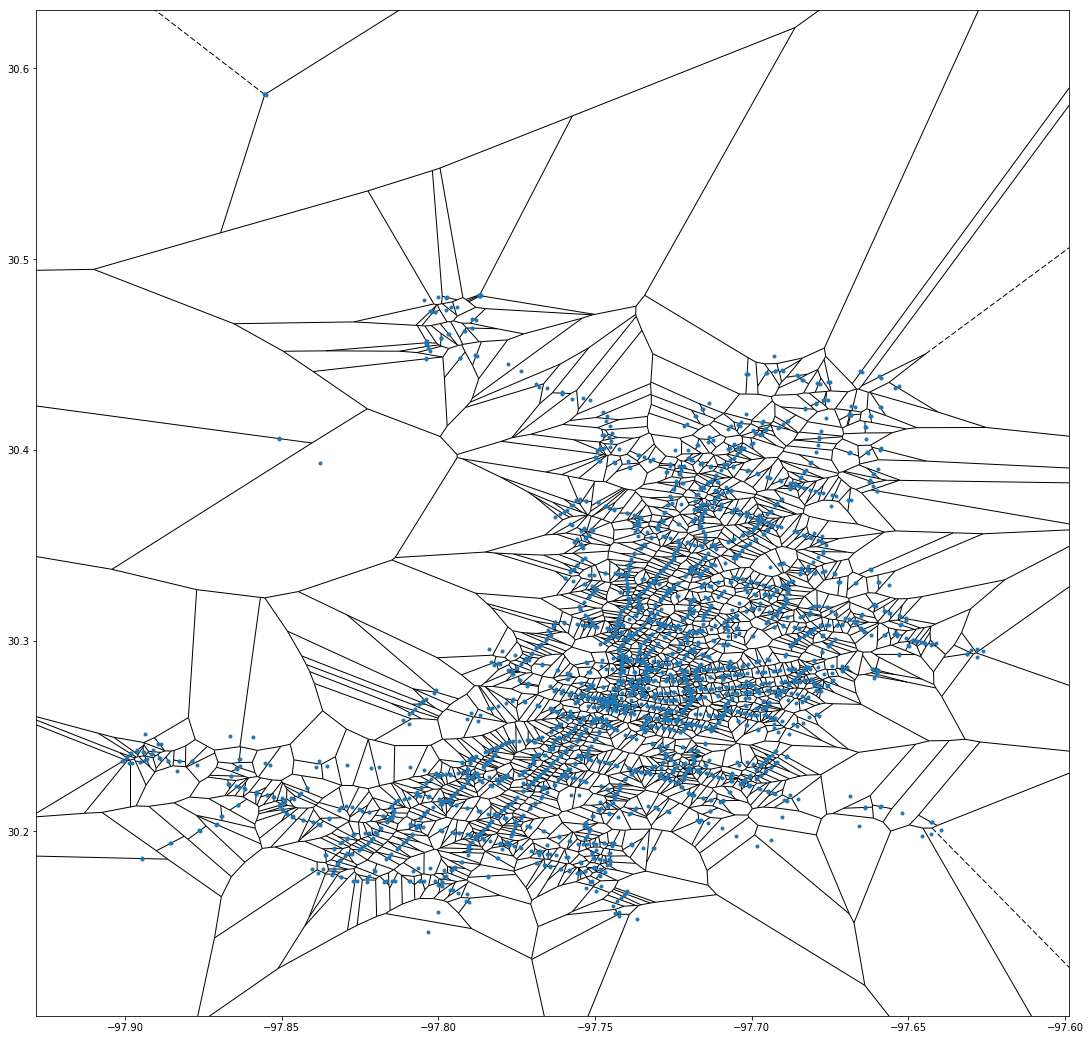

In [5]:
fig = scipy.spatial.voronoi_plot_2d(vor, show_vertices=False)
fig.set_size_inches(18.5, 18.5)

This plot looks a little squished. That's because we're plotting latitude and longitude data just using an X/Y coordinate plane. Let's use a tool more meant for plotting geographic data.

First, build [GeoJSON](http://geojson.org/) of the Voronoi diagram. I get a lot of help from this [StackOverflow answer about coloring in a Voronoi diagram](http://stackoverflow.com/a/20678647/101923). The main reason so much code is that we need to sort the vertices for each polygon counter-clockwise.

In [6]:
# Construct GeoJSON for the region.
# Based on 
# http://stackoverflow.com/a/20678647/101923
# to account for infinite regions.
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)


new_regions, new_vertices = voronoi_finite_polygons_2d(vor)
stop_regions = []
regions_geojson = {'type': 'FeatureCollection', 'features': stop_regions}

for busi, _ in enumerate(vor.point_region):
    coords = []
    for vtx in new_regions[busi]:
        coords.append(new_vertices[vtx].tolist())
        
    region_json = {
        'type': 'Feature',
        'id': int(busstops.stop_id[busi]),
        'properties': {
            'stop_id': int(busstops.stop_id[busi]),
        },
        'geometry': {
            'type': 'Polygon',
            'coordinates': [coords],
        },
    }
    stop_regions.append(region_json)
    
rs = json.dumps(regions_geojson)

Now plot the transit data using [Folium](https://github.com/python-visualization/folium), an excellent Python library for building [interactive Leaflet.js maps](http://leafletjs.com/).

Light areas are where buses are consistently on-time. Dark purple are areas where the buses are often off schedule.

In [7]:
austin_loc = (30.2957147,-97.7472336)
busmap = folium.Map(location=austin_loc)
busmap.choropleth(
    geo_str=rs,
    data=busstops,
    columns=['stop_id', 'schedule_deviation'],
    threshold_scale=[300, 600, 900, 1800, 3600, 7200],
    key_on='feature.id',
    fill_color='BuPu', fill_opacity=0.8, line_opacity=0.25,
    legend_name='Schedule Deviation (s)',
    reset=True)
busmap

That's great, but it doesn't include any information about tacos. How can I possibly use that to find a place to live?

I consider waiting for the bus an extra second because it is off schedule to be equivalent to being 1 meter away from tacos. So, let's compute a column indicating this preference.

In [8]:
# One second of bus lateness equals one meter of distance of distance to tacos in my preferences.
busstops = busstops.assign(tacotransit=pd.Series(busstops.tacodist + busstops.schedule_deviation).values)

Now, let's plot out the bus stops again, but this time considering both schedule deviation and taco proximity.

In [9]:
tacotransit = folium.Map(location=austin_loc)
tacotransit.choropleth(
    geo_str=rs,
    data=busstops,
    columns=['stop_id', 'tacotransit'],
    threshold_scale=[500, 1000, 1500, 2000, 4000, 8000],
    key_on='feature.id',
    fill_color='RdPu', fill_opacity=0.8, line_opacity=0.25,
    legend_name='Taco Transit (tims)',
    reset=True)
for _, taco in tacos.iterrows():
    folium.Marker([taco.latitude, taco.longitude], popup=taco.chain).add_to(tacotransit)
tacotransit

This gives us some great choices.

- On the south side, there appears to be reliable transit on William Cannon Drive, right near [Torchy's](https://www.google.com/maps/place/Torchy's+Tacos/@30.222917,-97.8438558,17z/data=!4m5!3m4!1s0x865b4b9766b63abb:0x33d2ddfeb2b0fa67!8m2!3d30.222326!4d-97.840415).
- On the east side, the [light rail at Plaza Saltillio Station](https://www.google.com/maps/place/Plaza+Saltillo+Station/@30.2621198,-97.7275117,15z/data=!4m5!3m4!1s0x0:0x16b2f9b53750ad4c!8m2!3d30.2621198!4d-97.7275117) looks reliable and is close to [El Chilito](http://www.elchilito.com/).
- On the north side, there are a few good choices, but the bus stops across Burnet Rd from [another Torchy's](https://www.google.com/maps/place/Torchy's+Tacos/@30.3235004,-97.7406555,17.48z/data=!4m5!3m4!1s0x8644ca5fb5f5f69b:0x39acbe41c4eec73f!8m2!3d30.3234369!4d-97.7392166) appear to be the most dependable.

Great! We've found some perfect places to live. They're close to reliable public transit and delicious tacos.